In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path

In [65]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [72]:
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [174]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df.sort_values(by='avg_test', ascending=False)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']

    ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                cmap="viridis")

In [146]:
results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"


In [147]:
# results

In [148]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [149]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 228/228 [00:47<00:00,  4.79it/s]


In [150]:
# all_results_paths

In [151]:
results_df

,subject,trial,ID,electrode,avg_test,time_bin,task
0,7,0,LT2H8-sub_7,LT2H8,0.498020,-0.500,word_length
1,7,0,LT2H8-sub_7,LT2H8,0.501266,-0.375,word_length
2,7,0,LT2H8-sub_7,LT2H8,0.492435,-0.250,word_length
3,7,0,LT2H8-sub_7,LT2H8,0.488687,-0.125,word_length
4,7,0,LT2H8-sub_7,LT2H8,0.492762,0.000,word_length
...,...,...,...,...,...,...,...
629083,3,0,F3d1-sub_3,F3d1,0.514070,1.875,gpt2_surprisal
629084,3,0,F3d1-sub_3,F3d1,0.486490,2.000,gpt2_surprisal
629085,3,0,F3d1-sub_3,F3d1,0.501325,2.125,gpt2_surprisal
629086,3,0,F3d1-sub_3,F3d1,0.486021,2.250,gpt2_surprisal


In [152]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [164]:
tasks

['global_flow',
 'onset',
 'word_gap',
 'gpt2_surprisal',
 'word_index',
 'word_head_pos',
 'local_flow',
 'face_num',
 'volume',
 'local_flow_angle',
 'speaker',
 'pitch',
 'speech',
 'frame_brightness',
 'word_part_speech',
 'global_flow_angle',
 'delta_pitch',
 'word_length',
 'delta_volume']

In [163]:
tasks = list(set(results_df.task))

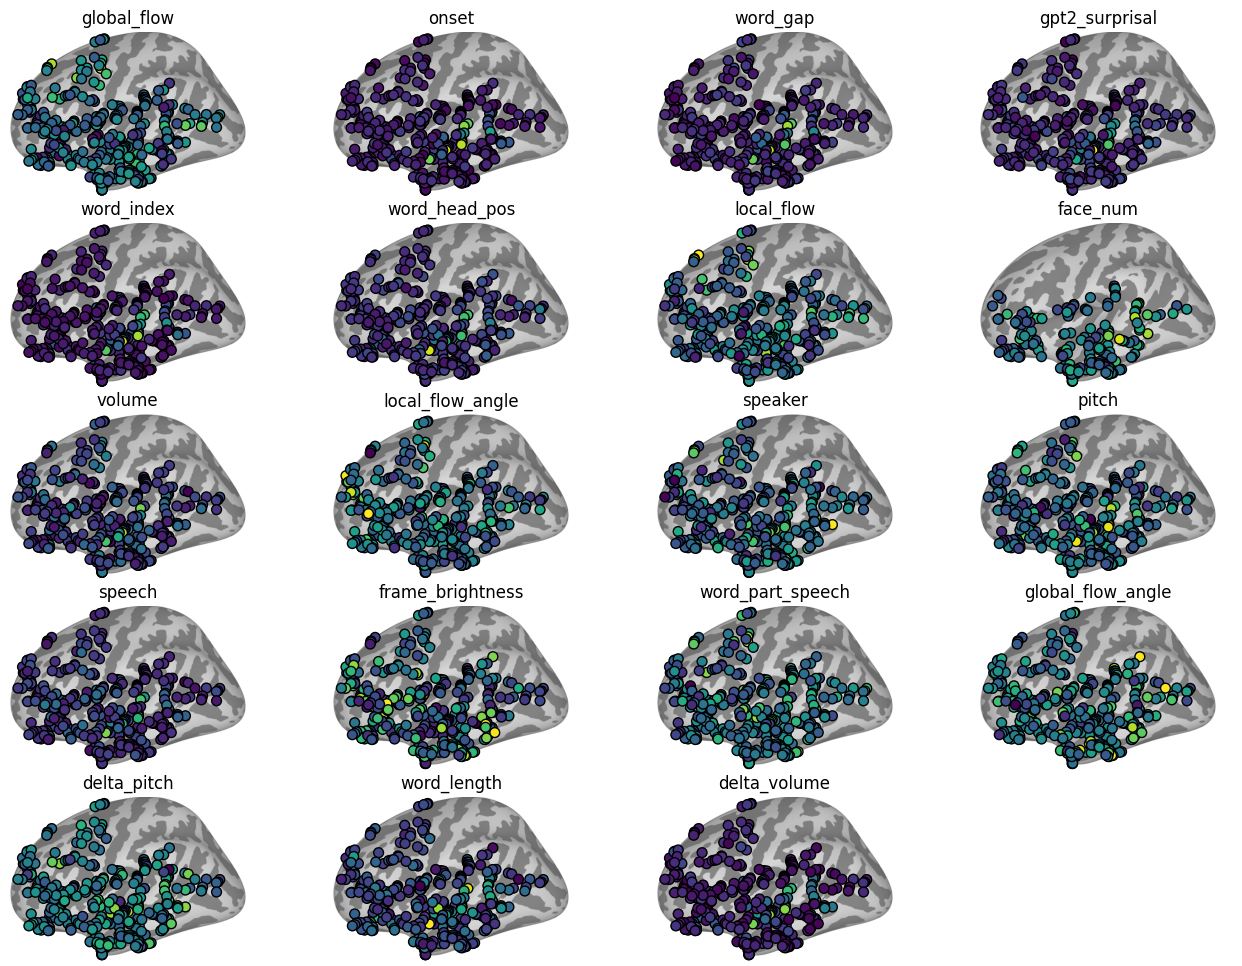

In [175]:
fig, axes = plt.subplots(5, 4, figsize=(16, 12))  # Adjust figsize as needed

# Loop through each subplot and add a simple plot or title

for i in range(5):
    for j in range(4):
        if i*j != 12:
            task = tasks[i*4+j]
            task_df = spatial_avg_results_df.loc[task]
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            plot_electrodes(merged_df, hemisphere="left", ax=axes[i, j], title=task)
            axes[i,j].set_title(task)
        else:
            axes[i,j].axis('off')